In [39]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 44.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


# Problemas do Case: 

1. Descreva graficamente os dados disponíveis, apresentando as principais estatísticas descritivas. Comente o por quê da escolha dessas estatísticas.

2. Explique como você faria a previsão do Churn a partir dos dados. Quais
variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de
problema estamos resolvendo (regressão, classificação)? Qual modelo
melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

3. Construa um pipeline de machine learning que realize a previsão de churn a
partir de um dataset CSV. Esse pipeline deve ser reproduzível e permitir
realizar uma previsão a partir de qualquer arquivo CSV com a mesma
estrutura de dados. O modelo utilizado pelo pipeline deve ser treinado com o
dataset Abandono_clientes.csv. Você deve nos enviar o repositório de código
com o pipeline.

4. Envie o resultado final do modelo em um arquivo com apenas duas colunas
(rowNumber, predictedValues) gerado ao rodar o pipeline de 3 no dataset
abandono_teste.csv em anexo.

# Resultados Obtidos

1. O dataset parece limpo, sem typos, outliers, valores faltantes. 3 colunas não fazem sentido entrar no modelo: RowNumber, CustomerId e Surname. Existe relação de dependencia clara, visível com gráficos e confirmadas com testes estatísticos, entre o target e algumas variáveis. O target é desbalanceado.

2. Comecei a modelagem com reglog por ser simples e facilmente interpretável. Transformei as variáveis categóricas com OneHotEncoder (não existe hierarquias nas variáveis categóricas para justificar um OrdinalEncoder) e as numéricas com StandardScaler.

3. Uma métrica importante aqui é o recall pois não queremos Falsos Negativos, já que geralmente esse erro é mais custoso para problemas de Churn. Mas também avaliei Precision e a matriz de confusão.

4. A reglog default não apresentou um resultado bom, 19% de recall. Por isso tentei 3 estratégias ainda com reglog: usar class_weights, mudar o limiar de probabilidade e balancear o dataset com aumentação de exemplos.

5. Dentre as 3 estratégias para reglog, decidi usar a reglog basal com limiar de 0.2 pois obtive um recall de 0.71 e precision de 0.37.

6. Testei uma RandomForest para usar um segundo modelo. Avaliar apenas um pode ser ruim pois podemos perder a chance de ter um ganho alto. Escolhi RandomForest porque é um modelo bem diferente que a reglog e é capaz de encontrar mapeamentos não-lineares entre entrada e saída.

# Próximos passos

1. Engenharia de features: talvez criar novas variáveis, embora seja difícil pensar em algo com esse dataset.
2. Testar mais modelos (talvez usando alguma biblioteca de automl) ou escolher melhor os hiperparâmetros.
3. Verificar se existe algum padrão nos exemplos de entrada que o modelo erra.
4. Usar técnicas de explicabilidade de modelos (como SHAP) para gerar insights para a área de negócios.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

from imblearn.combine import SMOTEENN 

In [2]:
df = pd.read_csv('/content/Abandono_clientes.csv')

In [ ]:
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# não tem valores faltantes
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
# nem linhas duplicadas
df.duplicated().sum()

0

In [ ]:
# coluna Geography não tem níveis raros ou valores estranhos
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [ ]:
# Gender também não possui valores estranhos
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [ ]:
# Tenure deve ser o número de meses e vai se 0 a 10
df['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

In [ ]:
# NumOfProducts parece ok
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [ ]:
# verifiquei se tem realmente só valores 0 e 1
df['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [ ]:
df['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [ ]:
# o target é um pouco desbalanceado
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

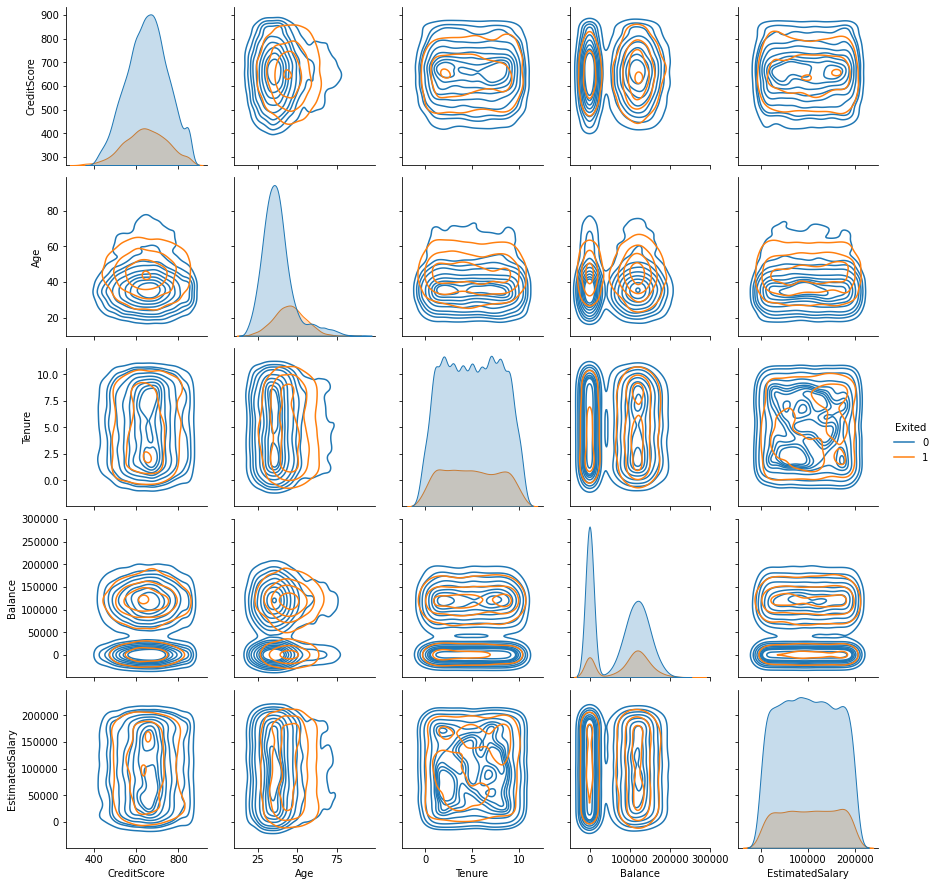

In [ ]:
# fiz o pairplot mais para ver se tem alguma relação entre as distribuições das variáveis e o target
# aparentemente tem pro CreditScore e Age
sns.pairplot( df[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']], hue='Exited', kind='kde' )

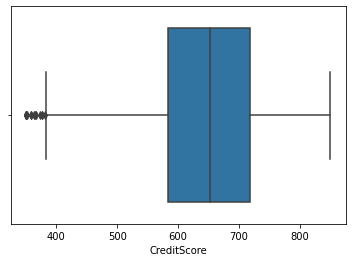

In [ ]:
# fazer boxplots para as variáveis contínuas para tentar identificar se tem algum outlier
sns.boxplot(x=df["CreditScore"])

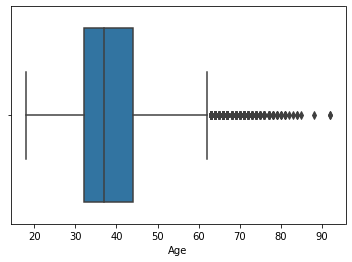

In [ ]:
sns.boxplot(x=df["Age"])

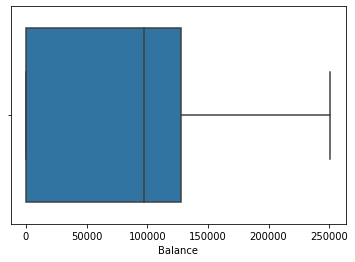

In [ ]:
sns.boxplot(x=df["Balance"])

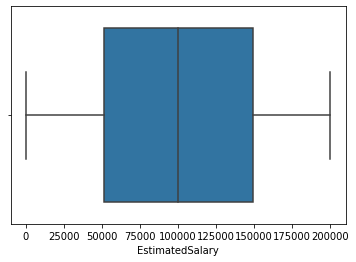

In [ ]:
sns.boxplot(x=df["EstimatedSalary"])

In [ ]:
# crosstab de variáveis categóricas com target
# apliquei teste qui quadrado quando desconfiei que tinha relação de dependência
pd.crosstab( df['Tenure'], df['Exited'] )

Exited,0,1
Tenure,,
0,318,95
1,803,232
2,847,201
3,796,213
4,786,203
5,803,209
6,771,196
7,851,177
8,828,197


In [ ]:
pd.crosstab( df['IsActiveMember'], df['Exited'] )

Exited,0,1
IsActiveMember,,
0,3547,1302
1,4416,735


In [ ]:
g, p, dof, expctd = chi2_contingency(pd.crosstab( df['IsActiveMember'], df['Exited'] ))
print(p)

8.785858269303703e-55


In [ ]:
pd.crosstab( df['NumOfProducts'], df['Exited'] )

Exited,0,1
NumOfProducts,,
1,3675,1409
2,4242,348
3,46,220
4,0,60


In [ ]:
g, p, dof, expctd = chi2_contingency(pd.crosstab( df['NumOfProducts'], df['Exited'] ))
print(p)

0.0


In [ ]:
pd.crosstab( df['HasCrCard'], df['Exited'] )

Exited,0,1
HasCrCard,,
0,2332,613
1,5631,1424


In [ ]:
g, p, dof, expctd = chi2_contingency(pd.crosstab( df['HasCrCard'], df['Exited'] ))
print(p)

0.49237236141554686


In [4]:
# Clientes da Alemanha tem uma proporção de Churn maior, talvez o serviço seja pior lá?
pd.crosstab( df['Geography'], df['Exited'] )

Exited,0,1
Geography,,
France,4204,810
Germany,1695,814
Spain,2064,413


In [6]:
g, p, dof, expctd = chi2_contingency(pd.crosstab( df['Geography'], df['Exited'] ))
print(p)

3.8303176053541544e-66


# Resumo da Análise Exploratória

1. O dataset não tem valores faltantes, duplicados, as variáveis categóricas não possuem valores estranhos como typos e também não possuem muitas categorias. As variáveis numéricas não possuem outliers.

2. O target é um pouco desbalanceado.

3. Existe uma relação de dependencia entre IsActiveMember e Geography com Exited, confirmada pelo teste qui-quadrado. Age, CreditScore,e NumOfProducts também parecem influenciar em Exited.

# Modelagem

1. Explique como você faria a previsão do Churn a partir dos dados. 

2. Quais variáveis e/ou suas transformações você utilizou e por quê?

>Eu removeria: RowNumber, CustomerId, Surname, pois nenhuma dessas possui valor preditivo para o modelo. Para transformações, usando a reglog/svm/redes neurais ou outro modelo que necessite de transformações, vou usar StandardScaler para as variáveis numéricas e OneHotEncoder para Sexo e Geography.


3. Qual tipo de problema estamos resolvendo (regressão, classificação)? 

>Classificação


4. Qual modelo melhor se aproxima dos dados e quais seus prós e contras? 

>Vou começar com um modelo simples como reglog e tentar depois algo mais complexo como decisiontree e ensembles.

5. Qual medida de performance do modelo foi escolhida e por quê?

>Provavelmente usarei recall pois em um problema de Churn é importante evitar o máximo possível de falsos positivos. Mas pretendo fazer a matriz de confusão porque acho fácil de explicar para a área de negócio.

In [7]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [3]:
X = df[['CreditScore', 'Geography','Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'EstimatedSalary']]
Y = df['Exited']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [16]:
reglog = make_pipeline( ColumnTransformer([("standard", StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
                                           ("onehot", OneHotEncoder(), ['Gender', 'Geography'])], remainder='passthrough'), 
                       LogisticRegression(random_state=42))

In [17]:
reglog.fit(X_train, y_train)
y_pred1 = reglog.predict(X_test)

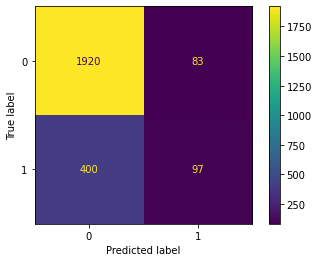

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred1)

In [19]:
print( accuracy_score(y_test, y_pred1) )
print( recall_score(y_test, y_pred1) )
print( precision_score(y_test, y_pred1) )

0.8068
0.19517102615694165
0.5388888888888889


# Resumo do primeiro modelo - Reglog basal

O primeiro modelo ficou com recall baixo, estamos capturando apenas 23% do churn. Nesse tipo de modelo o erro do Falso Negativo é mais custoso pois envolve perder a assinatura do cliente. O erro do Falso Positivo é menos custoso já que o gasto seria o da intervenção (ligar para o cliente e oferecer um desconto para alguém que não desistiria, por exemplo).

Nesse sentido, poderiamos usar 3 estratégias ainda com a reglog: 1. usar class_weight = 'balanced' para forçar o modelo a reconhecer a classe desbalanceada 2. podemos ser menos conservador e escolher um limiar de probabilidade baixo para identificar o Churn, por exemplo, acima de 30% podemos considerar que vai ser churn 3. Usar técnicas de balanceamento do dataset (SMOTE, oversampling, undersamling, etc).

Vou fazer as 3 abaixo:

## Estratégia 1 - pesos maior para a classe desbalanceada

In [25]:
reglog_balanced = make_pipeline( ColumnTransformer([("standard", StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
                                           ("onehot", OneHotEncoder(), ['Gender', 'Geography'])], remainder='passthrough'), 
                       LogisticRegression(class_weight='balanced', random_state=42))

In [26]:
reglog_balanced.fit(X_train, y_train)
y_pred2 = reglog_balanced.predict(X_test)

0.7096
0.7062374245472837
0.3770139634801289


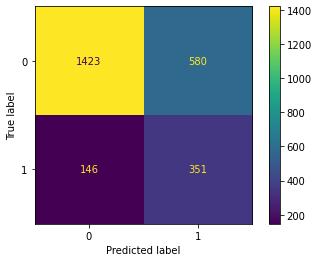

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred2)
print( accuracy_score(y_test, y_pred2) )
print( recall_score(y_test, y_pred2) )
print( precision_score(y_test, y_pred2) )

### Resultado estratégia 1

Tivemos uma melhora boa no recall ao custo de uma queda (esperada) na precision. Eu considero esse modelo muito melhor que o basal.

## Estratégia 2 - Escolher um outro limiar de probabilidade


Vou fazer um for testando vários limiares e plotando a matriz de confusão. Também vou fazer uma curva ROC/PR para ter uma ideia mais fina do comportamento do precision/recall em relação aos limiares.

In [28]:
reglog = make_pipeline( ColumnTransformer([("standard", StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
                                           ("onehot", OneHotEncoder(), ['Gender', 'Geography'])], remainder='passthrough'), 
                       LogisticRegression(random_state=42))

In [29]:
reglog.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['Gender', 'Geography'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

=== LIMIAR 0.1 ===


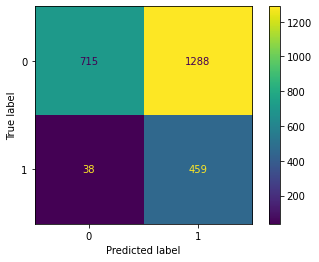

0.4696
0.9235412474849095
0.26273611906124783
=== LIMIAR 0.2 ===


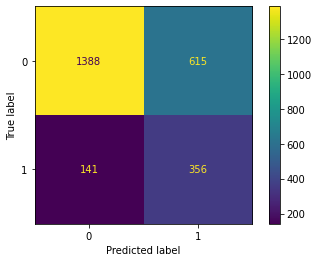

0.6976
0.716297786720322
0.3666323377960865
=== LIMIAR 0.30000000000000004 ===


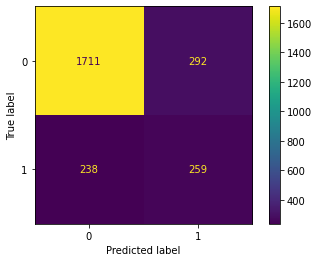

0.788
0.5211267605633803
0.47005444646098005
=== LIMIAR 0.4 ===


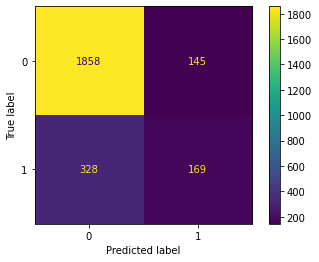

0.8108
0.34004024144869216
0.5382165605095541
=== LIMIAR 0.5 ===


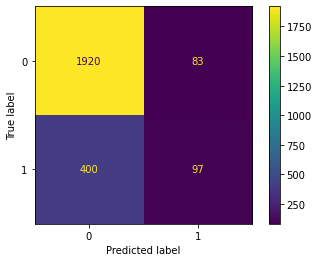

0.8068
0.19517102615694165
0.5388888888888889
=== LIMIAR 0.6 ===


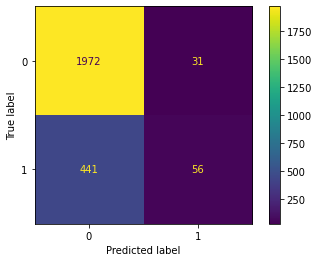

0.8112
0.11267605633802817
0.6436781609195402
=== LIMIAR 0.7000000000000001 ===


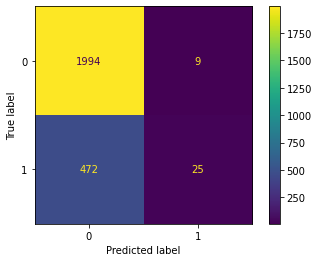

0.8076
0.05030181086519115
0.7352941176470589
=== LIMIAR 0.8 ===


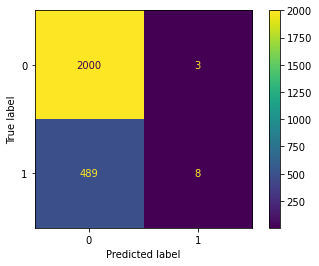

0.8032
0.01609657947686117
0.7272727272727273
=== LIMIAR 0.9 ===


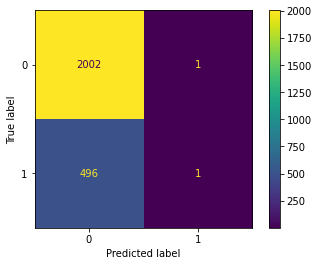

0.8012
0.002012072434607646
0.5


In [30]:
for limiar in np.arange(0.1, 1.0, 0.1):
    prob_limiar = reglog.predict_proba(X_test)[:, 1]
    y_pred_limiar = [ 1 if pred >= limiar else 0 for pred in prob_limiar]
    print('=== LIMIAR {} ==='.format(limiar) )
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_limiar)
    plt.show()
    print( accuracy_score(y_test, y_pred_limiar) )
    print( recall_score(y_test, y_pred_limiar) )
    print( precision_score(y_test, y_pred_limiar) )

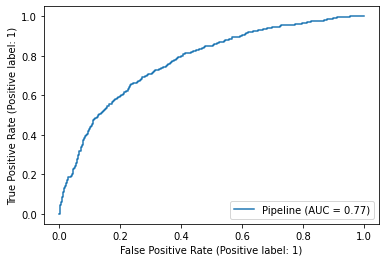

In [31]:
roc = RocCurveDisplay.from_estimator(reglog, X_test, y_test);

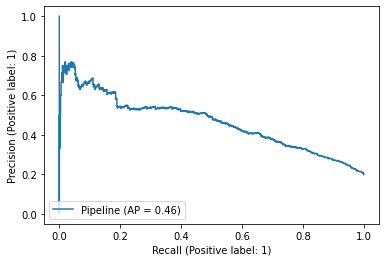

In [32]:
PrecisionRecallDisplay.from_estimator(reglog, X_test, y_test);

### Resultado estratégia 2

O limiar de 0.2 parece ser o melhor e o resultado fica parecido com o obtido na estratégia 1. Pela curva PR é possível ver que se quisermos uns 70% de recall vamos ter uns 40% de Precision.

## Estratégia 3 - Balanceando o Dataset

In [39]:
sme = SMOTEENN(random_state=42)
X_train_transformed = reglog[0].fit_transform(X_train)
X_test_transformed = reglog[0].fit_transform(X_test)
X_res, y_res = sme.fit_resample(X_train_transformed, y_train)

In [40]:
modelo_smote = LogisticRegression(random_state=42)
modelo_smote.fit(X_res, y_res)

LogisticRegression(random_state=42)

In [41]:
y_pred3 = modelo_smote.predict(X_test_transformed)

0.6392
0.7867203219315896
0.32940185341196293


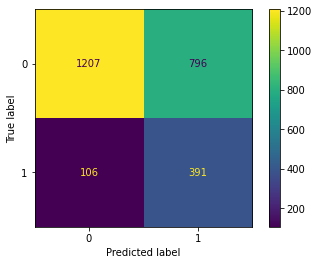

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred3)
print( accuracy_score(y_test, y_pred3) )
print( recall_score(y_test, y_pred3) )
print( precision_score(y_test, y_pred3) )

### Resultado estratégia 3

Esse resultado ficou bastante similar com as duas estratégias anteriores, perto de 80% de recall com 32% de precision. Poderíamos testar outras técnicas de balanceamento que estão implementadas no imblearn no futuro.

## Resultados das 3 Estratégias


|  Modelo |  Acurácia  | Recall  | Precision  |   
|---|---|---|---|
|  reglog basal | 0.80  | 0.19  | 0.54  |   
|  reglog classweights | 0.71  | 0.71  | 0.38  |   
|  reglog limiar 0.2 |  0.70 | 0.71  | 0.37  |   
| reglog smote | 0.64 | 0.79| 0.33 | 

Eu escolheria o reglog com limiar de 0.2. O motivo é a flexibilidade de usar esse modelo, como a escolha do limiar não depende do treinamento, podemos alterar o limiar sempre que o modelo precisasse ser executado. Por exemplo, para um certo mês poderíamos baixar o limiar para 0.1 caso a empresa tenha mais dinheiro para arcar com os custos dos falsos positivos e voltar a subir para 0.2 no mês seguinte. 

O reglog usando smote ficou com Recall de 0.79, a maior, mas perdeu 6% de acurácia e 5% de precision. Provavelmente conseguiríamos esse resultado escolhendo um limiar mais ajustado, como 0.25 ou algo assim.

## Outros Modelos?

Usamos apenas a reglog até agora, mas seria interessante testar outros modelos de ML. Eu geralmente faço isso de duas abordagens diferentes: testo modelos que possuem 'capacidades' diferentes por exemplo, testei um modelo linear agora (reglog) e posso testar um modelo não-linear como DecisionTree ou MLP; ou usar alguma ferramenta de automl como pycaret e testar vários de uma vez. Não gosto muito da última opção porque sinto um pouco de falta de controle no processo de criação do modelo. 

## Usando uma RandomForest


Para usar a RandomForest vou criar um GridSearch para escolher o melhor max_depth. Poderíamos incluir outros hiperparâmetros que influenciam bastante no desempenho como min_samples_split, ccp_alpha, etc mas apenas para fins de demonstração do método vou usar apenas max_depth (que já influencia bastante na performance).

Como métrica para o gridsearch, não vou deixar o default (acurácia) ou podemos ficar com um modelo com acurácia alta e recall baixo, por isso vou usar o f1_score, que é uma métrica de erro já balanceada.

In [63]:
param_grid = {
    'randomforestclassifier__max_depth': [2, 3, 4, 5, 6, 7, 8]

}

modelo_rf = make_pipeline( ColumnTransformer([("standard", StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
                                           ("onehot", OneHotEncoder(), ['Gender', 'Geography'])], remainder='passthrough'), 
                       RandomForestClassifier( random_state=0))
gs = GridSearchCV(modelo_rf, param_grid, scoring='f1')

gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Geography'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=0))]),
             param_grid={'randomforestclassifier__max_depth': [2, 3, 4, 5, 6, 7,
                                                               8]},
             scoring='f1')

In [64]:
best_rf = gs.best_estimator_
y_pred_rf = best_rf.predict(X_test)

0.8664
0.42052313883299797
0.8196078431372549


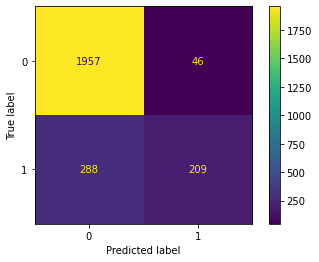

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
print( accuracy_score(y_test, y_pred_rf) )
print( recall_score(y_test, y_pred_rf) )
print( precision_score(y_test, y_pred_rf) )

### Resultados RandomForest basal

O resultado da RandomForest ficou bem melhor que a reglog basal. Vou testar com class_weight.

In [66]:
param_grid = {
    'randomforestclassifier__max_depth': [2, 3, 4, 5, 6, 7, 8]

}

modelo_rf2 = make_pipeline( ColumnTransformer([("standard", StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
                                           ("onehot", OneHotEncoder(), ['Gender', 'Geography'])], remainder='passthrough'), 
                       RandomForestClassifier(class_weight='balanced', random_state=0))
gs2 = GridSearchCV(modelo_rf2, param_grid, scoring='f1')

gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Geography'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=0))]),
             param_grid={'randomforestclassifier__max_depth': [2, 3, 4, 5, 6, 7,
                                                               8]},
             scoring='f1')

In [67]:
best_rf2 = gs2.best_estimator_
y_pred_rf2 = best_rf2.predict(X_test)

0.8164
0.7263581488933601
0.5277777777777778


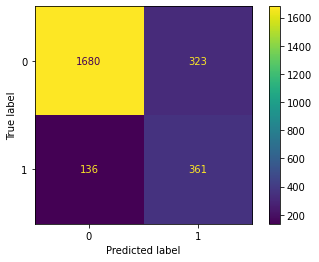

In [68]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf2)
print( accuracy_score(y_test, y_pred_rf2) )
print( recall_score(y_test, y_pred_rf2) )
print( precision_score(y_test, y_pred_rf2) )

### Usando outro limiar

Como o class_weight deu um resultado ainda melhor que o reglog, pois manteve o recall de 72% mas melhorou a precision em 15%, vou tentar encontrar um limiar interessante.

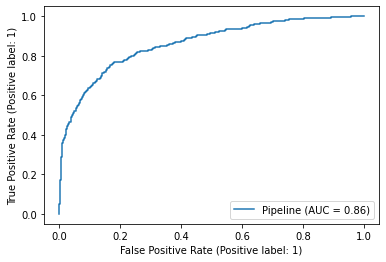

In [69]:
roc = RocCurveDisplay.from_estimator(best_rf, X_test, y_test);

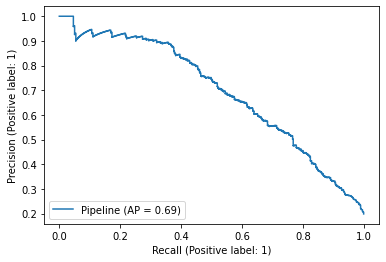

In [70]:
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test);

In [80]:
p, r, t = precision_recall_curve(y_test, best_rf.predict_proba(X_test)[:,1])

In [81]:
r[(r >= 0.70) & (r <=0.72)]

array([0.71830986, 0.71830986, 0.71830986, 0.71830986, 0.71830986,
       0.71830986, 0.71629779, 0.71629779, 0.71629779, 0.71428571,
       0.71428571, 0.71428571, 0.71428571, 0.71428571, 0.71428571,
       0.71428571, 0.71428571, 0.71428571, 0.71428571, 0.71428571,
       0.71428571, 0.71227364, 0.71227364, 0.71227364, 0.71026157,
       0.7082495 , 0.7082495 , 0.70623742, 0.70422535, 0.70221328,
       0.70221328, 0.70020121])

In [82]:
p[(r >= 0.70) & (r <=0.72)]

array([0.54255319, 0.543379  , 0.54420732, 0.54503817, 0.54587156,
       0.5467075 , 0.54601227, 0.546851  , 0.54769231, 0.54699538,
       0.54783951, 0.54868624, 0.5495356 , 0.5503876 , 0.55124224,
       0.55209953, 0.5529595 , 0.55382215, 0.5546875 , 0.55555556,
       0.55642633, 0.55572998, 0.55660377, 0.55748031, 0.55678233,
       0.55608215, 0.55696203, 0.5562599 , 0.55555556, 0.55484897,
       0.55573248, 0.55502392])

In [83]:
t[ ((r >= 0.70) & (r <=0.72))[:-1]]

array([0.23692152, 0.23734688, 0.23739969, 0.23763554, 0.2377904 ,
       0.23779775, 0.23877389, 0.23896397, 0.23928108, 0.2396225 ,
       0.23990143, 0.24003869, 0.2401898 , 0.24069805, 0.241355  ,
       0.24144234, 0.24172929, 0.24176799, 0.24203849, 0.24247626,
       0.24261416, 0.24276922, 0.24277933, 0.24355846, 0.24371718,
       0.24392643, 0.24415371, 0.24443485, 0.24444042, 0.24487015,
       0.24490872, 0.24505273])

### Escolhendo o limiar

Para um recall em torno de 70% e Precision em torno de 54-55% preciamos escolher um limiar entre 0.237 e 0.245. Vou escolher o 0.237.

# Comparando Reglog e RandomForest

|  Modelo |  Acurácia  | Recall  | Precision  |   
|---|---|---|---|
|  reglog basal | 0.80  | 0.19  | 0.54  |   
|  reglog classweights | 0.71  | 0.71  | 0.38  |   
|  reglog limiar 0.2 |  0.70 | 0.71  | 0.37  |   
| reglog smote | 0.64 | 0.79| 0.33 | 
| randomforest basal | 0.86 | 0.42| 0.81 | 
| randomforest classweights | 0.81 | 0.72| 0.52 | 
| randomforest limiar 0.237 | 0.81 | 0.72| 0.54 | 


Na comparação entre os dois modelos, conseguimos o mesmo 0.72 de recall com quase 15% de precision a mais. Provavelmente existem padrões não lineares que a reglog não conseguiu pegar. 

Meu modelo final será a randomforest com limiar de 0.237.

# Salvando o modelo

In [101]:
import pickle

In [102]:
with open(r"modelo.pkl", "wb") as output_file:
    pickle.dump( best_rf, output_file )

# Fazendo previsões usando a pipeline

In [103]:
def predict_churn(filename, limiar=0.237, output_filename='saida.csv'):

    # Le o csv de entrada. Esse csv precisa ter a mesma estrutura de entrada (nome das colunas)
    df_teste = pd.read_csv(filename, sep=';')
    rownumber = df_teste['RowNumber'] #guarda RowNumber
    X_teste = df_teste[['CreditScore', 'Geography','Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'EstimatedSalary']]

    # Lê o modelo salvo
    with open(r"modelo.pkl", "rb") as input_file:
        best_rf = pickle.load( input_file )

    # Faz a previsão usando o limiar. O default é de 0.237
    y_pred_probas = best_rf.predict_proba(X_teste)[:, 1]
    y_pred_teste = [ 1 if pred >= limiar else 0 for pred in y_pred_probas ]

    # Cria o arquivo com as saídas, o nome default é saida.csv
    output = pd.DataFrame()
    output['rowNumber'] = rownumber
    output['predictedValues'] = y_pred_teste
    output.to_csv(output_filename, index=False)

In [104]:
predict_churn('Abandono_teste.csv', output_filename='saida2.csv')